In [43]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import copy
from sklearn.cluster import MiniBatchKMeans
from scipy.ndimage import gaussian_filter
from skimage.morphology import binary_closing, binary_opening
from skimage import measure

from load_image import load_image
from diamond import diamond

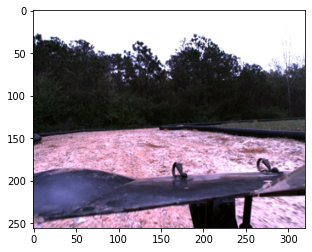

In [58]:
im = load_image('all_images/img1264.png')
plt.imshow(im)
plt.show()

In [59]:
# Gaussian blur to make the road surface look more even
im_blur = gaussian_filter(im, sigma=1)

In [60]:
def cluster_image(im: np.ndarray, K = 3) -> np.ndarray:
    X = im.reshape(-1, 3)
    batch_size = X.shape[0] // 10
    kmeans = MiniBatchKMeans(n_clusters=K, batch_size=batch_size).fit(X)

    # Generate clustered image
    im_c = np.zeros(im.shape)
    im_c = im_c.reshape(-1, 3)
    for label in np.unique(kmeans.labels_):
        im_c[kmeans.labels_ == label] = kmeans.cluster_centers_[label]
    im_c = im_c.reshape(im.shape) / 255
    
    return im_c, kmeans


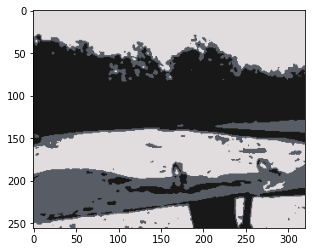

In [61]:
im_c, kmeans = cluster_image(im_blur)
plt.imshow(im_c)

In [62]:
print(mean_labels)
np.dot(kmeans.cluster_centers_[..., :3], [0.2989, 0.5870, 0.1140]) / 255

[0.94772776 0.15032897 0.48309524]


array([0.36088448, 0.87335562, 0.09602544])

[0.34515579 0.36214392 0.39595559]


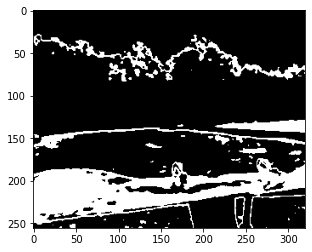

In [63]:
# Get mask for midtone
# mean_labels = np.mean(kmeans.cluster_centers_, axis=1) / 255
gray_labels = np.dot(kmeans.cluster_centers_[..., :3], [0.2989, 0.5870, 0.1140]) / 255
midtone_label = np.argsort(gray_labels)[1]
midtone_value = kmeans.cluster_centers_[midtone_label] / 255
print(midtone_value)
mask = (im_c == midtone_value)
mask = mask.astype('float64').mean(axis=2)
plt.imshow(mask, cmap='gray')

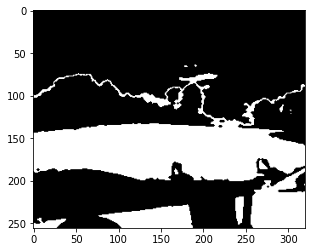

In [54]:
# Binary closing
kernel = diamond(3)
mask_closed = binary_closing(mask, kernel)
plt.imshow(mask_closed, cmap='gray')

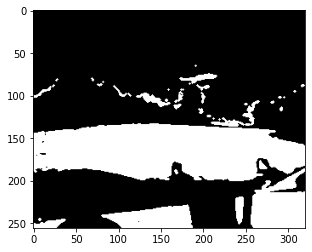

In [56]:
# Binary opening
mask_closed = binary_opening(mask, kernel)
plt.imshow(mask_closed, cmap='gray')


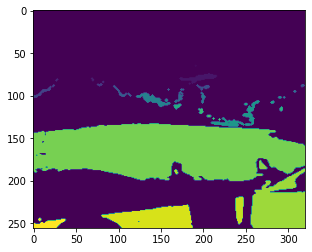

In [57]:
# Connected components
cc = measure.label(mask_closed, background=0)
plt.imshow(cc)

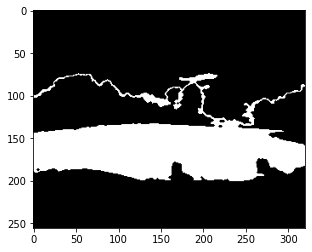

In [39]:
# Assume the largest group is the road
def get_largest_component(cc: np.ndarray) -> np.ndarray:
    cc_flat = cc.reshape(-1)
    unique_labels = np.sort(np.unique(cc))
    counts = []
    for label in unique_labels:
        counts.append(len(cc_flat[cc_flat==label]))
    ind_max = np.argmax(counts[1:]) # Ignore 0. That's background
    return unique_labels[1:][ind_max]

largest_cc = get_largest_component(cc)
mask_main_cc = np.zeros(cc.shape)
mask_main_cc[cc == largest_cc] = 1
plt.imshow(mask_main_cc, cmap='gray')

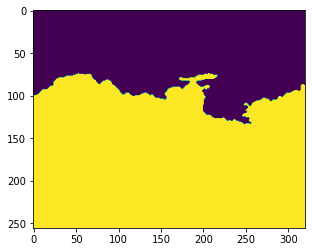

In [40]:
# Get connected components of the reverse mask to fill in holes
reverse_mask = 1 - mask_main_cc
cc_rev = measure.label(reverse_mask, background=0)
cc_rev_flat = cc_rev.reshape(-1)
unique_labels = np.unique(cc_rev)
counts = []
for label in unique_labels:
    counts.append(len(cc_rev_flat[cc_rev_flat==label]))
max_size = np.max(counts)
for label in unique_labels:
    if counts[label] < max_size:
        cc_rev[cc_rev==label] = 0

cc_rev[cc_rev > 0] = 1
final_mask = 1 - cc_rev
final_mask = final_mask.astype(np.float)
plt.imshow(final_mask)

In [29]:
def get_road_mask(im: np.ndarray) -> np.ndarray:
    # Gaussian blur to make the road surface look more even
    im_blur = gaussian_filter(im, sigma=1)

    # K-Means clustering to get road
    im_c, kmeans = cluster_image(im_blur)
    mean_labels = np.mean(kmeans.cluster_centers_, axis=1) / 255
    midtone_label = np.argsort(mean_labels)[1]
    midtone_value = kmeans.cluster_centers_[midtone_label] / 255

    # midtone mask (assume midtone contains road)
    mask = (im_c == midtone_value)
    mask = mask.astype('float64').mean(axis=2)

    # Binary closing
    kernel = diamond(3)
    mask_closed = binary_closing(mask, kernel)

    # Connected components
    cc = measure.label(mask_closed, background=0)

    # Assume the largest group is the road
    largest_cc = get_largest_component(cc)
    mask_main_cc = np.zeros(cc.shape)
    mask_main_cc[cc == largest_cc] = 1

    # Get connected components of the reverse mask to fill in holes
    reverse_mask = 1 - mask_main_cc
    cc_rev = measure.label(reverse_mask, background=0)
    cc_rev_flat = cc_rev.reshape(-1)
    unique_labels = np.unique(cc_rev)
    counts = []
    for label in unique_labels:
        counts.append(len(cc_rev_flat[cc_rev_flat==label]))
    max_size = np.max(counts)
    for label in unique_labels:
        if counts[label] < max_size:
            cc_rev[cc_rev==label] = 0

    cc_rev[cc_rev > 0] = 1
    final_mask = 1 - cc_rev
    final_mask = final_mask.astype(np.float)
    return final_mask

In [30]:
import glob
from tqdm import tqdm

image_names = glob.glob('images/img*.png')
images = []
road_masks = []
road_overlays = []

for image in tqdm(image_names):
    im = load_image(image)
    road_mask = get_road_mask(im)
    im_with_mask = copy.copy(im)
    im_with_mask[road_mask == 1] = [255, 0, 0]
    images.append(im)
    road_masks.append(road_mask)
    road_overlays.append(im_with_mask)

100%|██████████| 9/9 [00:39<00:00,  4.38s/it]


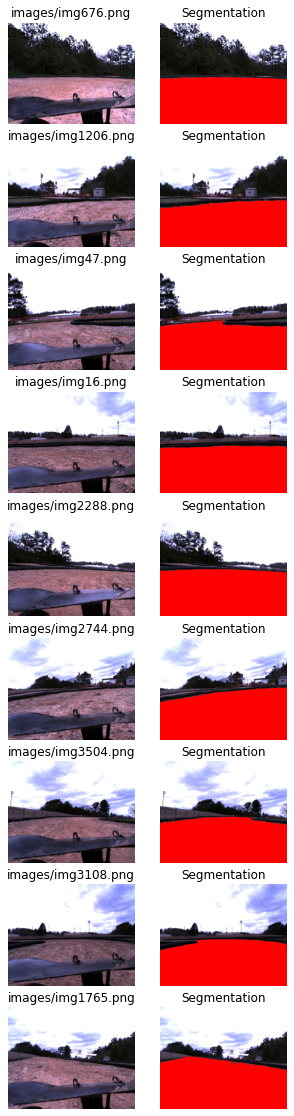

In [31]:
import matplotlib.pyplot as plt
import copy

fig, ax = plt.subplots(len(image_names), 2)
fig.set_figheight(20)
fig.set_figwidth(5)
for r in range(len(image_names)):
    ax[r, 0].set_title(image_names[r])
    ax[r, 0].imshow(images[r])
    ax[r, 0].axis('off')

    ax[r, 1].set_title('Segmentation')
    ax[r, 1].imshow(road_overlays[r])
    ax[r, 1].axis('off')